In [70]:
import math, random
from tqdm.notebook import tqdm
from tabulate import tabulate
from omnibelt import save_yaml
import omnifig as fig
from stox import misc
from stox.general import load_symbol_table
fig.initialize()

In [3]:
symbols_table = load_symbol_table()
eur = {yfsym: info for yfsym, info in symbols_table.items() if info['ibkr-contract']['currency'] == 'EUR'}
len(symbols_table), len(eur)

(273, 240)

In [4]:
date = 'last'
config = fig.create_config('container', api={'_type': 'ib-extractor', 'using_notebook': True}, 
						   currency='USD', exchange=['NYSE', 'NASDAQ'], return_all=True)
_container_source = config.peek('container')
def create_container(yfsym):
	with _container_source.silence():
		ctx = _container_source.create()
	ctx['ticker'] = yfsym
	ctx['date'] = date
	return ctx
def search(query):
	config.push('query', query)
	cts = fig.run_script('ib-search', config)
	return cts
def view(cts):
	print(tabulate([(i, c.symbol, c.currency, c.primaryExchange, c.conId, c.description) for i, c in reversed(list(enumerate(cts)))], headers=['index', 'symbol', 'currency', 'exchange', 'conId', 'description']))
config.silent = True
ibe = config.pull('api')

ERROR:ib_insync.wrapper: Error 321, reqId 2147483647: Error validating request.-'cG' : cause - The API interface is currently in Read-Only mode.
ERROR:ib_insync.wrapper: Error 321, reqId -1: Error validating request.-'ce' : cause - The API interface is currently in Read-Only mode.
ERROR:ib_insync.ib: open orders request timed out
ERROR:ib_insync.ib: completed orders request timed out


In [5]:
cts = search('SAP')
view(cts)

  index  symbol    currency    exchange        conId  description
-------  --------  ----------  ----------  ---------  ----------------------------
     34  FINN13    MXN         MEXI        142899881  ASESOR DE ACTIVOS PRISMA SAP
     33  BM0       EUR         FWB2        603526044  BETTERWARE DE MEXICO SAPI DE
     32  9776      JPY         TSEJ        131085491  SAPPORO CLINICAL LABORATORY
     31  2501      JPY         TSEJ         13905311  SAPPORO HOLDINGS LTD
     30  FMTY14    MXN         MEXI        181638660  FIBRA MTY SAPI DE CV
     29  BRD       SGD         SGX         224305229  SAPPHIRE CORP LTD
     28  SPNS      ILS         TASE        330867313  SAPIENS INTERNATIONAL CORP
     27  SPI1      EUR         FWB2        469136622  SAPPI LIMITED
     26  ASA       NOK         OSE         421653762  ATLANTIC SAPPHIRE ASA
     25  SAPPHIRE  INR         NSE         527046201  SAPPHIRE FOODS INDIA LTD
     24  SAPIAB    SEK         VALUE       423903615  SALTANGEN PROPERTY INVE

In [6]:
todo = [yfsym for yfsym, info in eur.items() if 'partners' not in info]
len(todo)

240

In [65]:
yfsym = random.choice(todo)
ctx = create_container(yfsym)
yfsym, symbols_table[yfsym]['ibkr-contract']['symbol'], ctx['company_short_name'], ctx['country'], ctx['sector']

('REN.AS', 'REN', 'RELX', 'United Kingdom', 'Industrials')

In [73]:
contexts = {}
sols = {}
bad = {}

In [75]:
itr = tqdm(todo)
for yfsym in itr:
	if yfsym in sols or yfsym in bad:
		continue
	itr.set_description(f'{yfsym} (bad={len(bad)})')
	
	if yfsym not in contexts:
		contexts[yfsym] = create_container(yfsym)
	ctx = contexts[yfsym]
	
	try:
		long_name = ctx['company_name']
		company_name = ctx['company_short_name']
		assert company_name is not None
	except Exception as e:
		bad[yfsym] = e
	else:
		ibsym = symbols_table[yfsym]['ibkr-contract']['symbol']
		
		srcs = [search(ibsym), search(company_name)]
		srcs = [[ct for ct in src if ct.currency == 'USD'] for src in srcs]
		locs = [{ct.conId for ct in src} for src in srcs]
		cts = []
		for src in srcs:
			cts.extend(ct for ct in src if ct not in cts)
		
		def contract_score(ct):
			return (sum(ct.conId in loc for loc in locs),
				max(misc.str_similarity(long_name.lower(), ct.description.lower()), 
					misc.str_similarity(company_name.lower(), ct.description.lower())))
		picks = sorted([ct for ct in cts if ct.currency == 'USD'], key=contract_score, reverse=True)
		
		sols[yfsym] = picks
len(sols), len(bad)

  0%|          | 0/240 [00:00<?, ?it/s]

(236, 4)

In [77]:
print(tabulate([[yfsym, repr(e)] for yfsym, e in bad.items()], headers=['symbol', 'error'])) # ['MOCORP.HE', 'NDA FI.HE', 'NDA.ST', 'URW.AS']

symbol     error
---------  ----------------
MOCORP.HE  AssertionError()
NDA FI.HE  AssertionError()
NDA.ST     AssertionError()
URW.AS     AssertionError()


In [78]:
# print(tabulate([(i, c.symbol, c.currency, c.primaryExchange, c.conId, c.description, contract_score(c)[-1]) for i, c in reversed(list(enumerate(picks)))], headers=['index', 'symbol', 'currency', 'exchange', 'conId', 'description', 'score']))

In [80]:
def contract_context_score(ct, ctx):
	long_name = ctx['company_name']
	company_name = ctx['company_short_name']
	return (sum(ct.conId in loc for loc in locs),
		max(misc.str_similarity(long_name.lower(), ct.description.lower()), 
			misc.str_similarity(company_name.lower(), ct.description.lower())))

In [85]:
scores = {yfsym: contract_context_score(sols[yfsym][0], contexts[yfsym])[-1] for yfsym in sols.keys() if len(sols[yfsym]) > 0}
pts = list(scores.values())
len(pts)

195

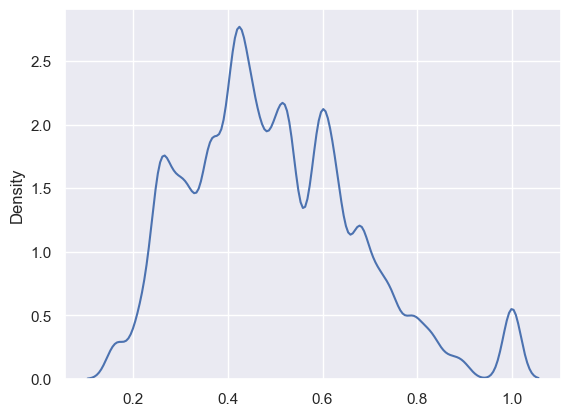

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
# %matplotlib inline
# sns.displot(pts, bins=100);
sns.kdeplot(pts, bw_adjust=0.3);

In [117]:
high = {yfsym: sols[yfsym][0] for yfsym in sols.keys() if len(sols[yfsym]) }#and scores.get(yfsym, 0) >= 0.4}
len(high)

195

In [121]:
table = sorted([[
	scores[yfsym], 
	yfsym, 
	contexts[yfsym]['country'], 
	contexts[yfsym]['sector'],
	contexts[yfsym]['market_cap'],
	contexts[yfsym]['company_short_name'], 
	symbols_table[yfsym]['ibkr-contract']['symbol'], 
	c.symbol, 
	c.description,
	c.conId,
	c.currency,
	c.primaryExchange,
	c.exchange,
] 
				for yfsym, c in high.items()], key=lambda r: r[0], reverse=True)
# print(tabulate(table, headers=['symbol', 'country', 'company', 'euro', 'score', 'ibkr','ibkr-desc']))

In [123]:
import pandas as pd
df = pd.DataFrame(table, columns=['score', 'symbol', 'country', 'sector', 'market_cap', 'company', 'ibkr', 'ibkr-desc', 'ibkr-conId', 'ibkr-currency', 'ibkr-exchange', 'ibkr-primaryExchange', 'ibkr-exchange'])
df.to_csv(misc.assets_root() / 'ibkr-company-matches.csv');